In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../helper_functions')
sys.path.append('../objects')
sys.path.append('../../machineLearning/helpers/')
sys.path.append('/home/ssd2tb/dturcu/electric_fish_processed_data/')

import copy
import time
import dill
import numpy as np
import pandas as pd
import h5py
import scipy.io as io
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go
from tabulate import tabulate
import random

In [3]:
from prefixes import remove_prefix, add_prefix
from conversions import rho24sig, convert2mainSI

from ElectricObject import ElectricObject

from Worm import Worm
from Worm_SmallSpherical import SmallSphericalWorm

from Fish import Fish
from FishGeneration import FishGeneration
from Fish_IceCreamCone import IceCreamConeFish
from Fish_Capsule import CapsuleFish

from Boundaries import *
from Aquarium import Aquarium
from Aquarium_SinglePlane import SinglePlaneAquarium

from load_data import load_data_full

from assertion_tests import run_tests

from find_EI_ids import find_EI_ids, find_base_ids
run_tests()

'Success!'

## Load the processed data

In [4]:
# file_name = '../data/processed/data_220607_Large_dataset_with_receptors_responses'  # extensions are .pkl and .hdf5 for the two files storing the dataset
# file_name = '../data/processed/data_220623_Small_dataset_Lateral_boundary_Receptors_responses'  # extensions are .pkl and .hdf5 for the two files storing the dataset
# file_name = '../data/processed/data_220623_Single_receptor_Three_boundaries_Tail_positions_effects_on_DLZ'  # extensions are .pkl and .hdf5 for the two files storing the dataset
# file_name = '../data/processed/data_220610_Large_dataset_with_receptors_responses'
# file_name = '../data/processed/data_230120_SMALL_YES_manyObjects_NO_boundaries_NO_tail_ONE_conductivity'
# file_name = '../data/processed/data_230123_YES_manyObjects_NO_boundaries_NO_tail_ONE_conductivity'
# file_name = '/home/ssd2tb/dturcu/electric_fish_processed_data/data_230123_YES_manyObjects_NO_boundaries_NO_tail_ONE_conductivity'
file_name = '/home/ssd2tb/dturcu/electric_fish_processed_data/data_230324_YES_manyObjects_NO_boundaries_NO_tail_ONE_conductivity_OnlyFEW_R_C'
use_torch = False
find_base_id_for_each_EI=False

[properties_dict,
properties_ids_base, properties_ids_pert,
base_EI, base_LEODs, pert_EI, pert_LEODs,
# aquarium properties
water_conductivities, boundary_normals, boundary_displacements,
# fish properties
tail_lateral_angle, tail_dor_ven_angle, tail_location_percent, fish_yaw, fish_pitch, fish_roll,
# worm properties
resistances, capacitances, worm_radii, worm_xs, worm_ys, worm_zs,
# statistics of receptor responses
receptors_avg, receptors_std,
# objects used in simulations
aqua_objs, fish_objs, worm_objs] = \
    load_data_full(file_name=file_name, use_torch=use_torch, find_base_id_for_each_EI=find_base_id_for_each_EI)
    
print(properties_ids_base.shape)
print(properties_ids_pert.shape)

f = h5py.File(f'{file_name}_IMGs.hdf5', 'r')
IMG_pert_EI = f['pert_EI']

Data loaded.
Data extracted.
     Component 0: water conductivity
     Component 1: boundary normals
     Component 2: boundary displacements
     Component 3: tail lateral angle
     Component 4: tail dor ven angle
     Component 5: tail location percent
     Component 6: fish yaw
     Component 7: fish pitch
     Component 8: fish roll
     Component 9: resistances
     Component 10: capacitances
     Component 11: worm radii
     Component 12: worm xs
     Component 13: worm ys
     Component 14: worm zs
     Component 15: pert EI
     Component 16: base EI
(1, 10)
(21000000, 17)


## Select a particular experiment to visualize

In [5]:
names = [#'water_conductivities', 'boundary_normals', 'boundary_displacements', 'tail_lateral_angle',  'tail_dor_ven_angle', 'tail_location_percent', 'fish_yaw', 'fish_pitch', 'fish_roll', 
'resistances', 'capacitances', 'worm_radii', 'worm_xs', 'worm_ys', 'worm_zs',]
variables = [
    #  [f'ID {i}: {x:.2f} S/m' for i, x in enumerate(water_conductivities)], 
    #  [f'ID {i}: {x}' for i, x in enumerate(boundary_normals)], 
    #  [[f'{i}: {abs(d)*1000 if abs(d) < 1 else np.inf:.0f}' for i, d in enumerate(b)] for b in boundary_displacements],
    #  [f'ID {i}: {x}' for i, x in enumerate(tail_lateral_angle)], 
    #  [f'ID {i}: {x}' for i, x in enumerate(tail_dor_ven_angle)],
    #  [f'ID {i}: {x}' for i, x in enumerate(tail_location_percent)],
    #  [f'ID {i}: {x:.2f} deg' for i, x in enumerate(fish_yaw)],
    #  [f'ID {i}: {x:.2f} deg' for i, x in enumerate(fish_pitch)],
    #  [f'ID {i}: {x:.2f} deg' for i, x in enumerate(fish_roll)],
     [f'ID {i}: {x/1e3:.1f} *1e3 Ohm' for i, x in enumerate(resistances)],
     [f'ID {i}: {x*1e9:.1f} *1e-9 F ' for i, x in enumerate(capacitances)],
     [f'ID {i}: {x*1000:.2f} mm' for i, x in enumerate(worm_radii)],
     [f'ID {i}: {x*1000:.2f} mm' for i, x in enumerate(worm_xs)],
     [f'ID {i}: {x*1000:.2f} mm' for i, x in enumerate(worm_ys)],
     [f'ID {i}: {x*1000:.2f} mm' for i, x in enumerate(worm_zs)],
    ]
max_len = np.max([len(x) for x in variables])
variables = [vrbls + [None]*(max_len-len(vrbls)) for vrbls in variables]
variables = [list(x) for x in zip(*variables)]


In [6]:
# f = open('table.txt', 'w')
# print(tabulate([names] + variables, headers='firstrow', tablefmt='grid'), file=f)
print(tabulate([names] + variables, headers='firstrow', tablefmt='grid'))

+----------------------+---------------------+-----------------+------------------+-----------------+-----------------+
| resistances          | capacitances        | worm_radii      | worm_xs          | worm_ys         | worm_zs         |
+======================+=====================+=================+==================+=================+=================+
| ID 0: 0.2 *1e3 Ohm   | ID 0: 0.2 *1e-9 F   | ID 0: 1.50 mm   | ID 0: 15.00 mm   | ID 0: 18.00 mm  | ID 0: -15.00 mm |
+----------------------+---------------------+-----------------+------------------+-----------------+-----------------+
| ID 1: 0.4 *1e3 Ohm   | ID 1: 0.4 *1e-9 F   | ID 1: 2.00 mm   | ID 1: 10.00 mm   | ID 1: 18.50 mm  | ID 1: -13.50 mm |
+----------------------+---------------------+-----------------+------------------+-----------------+-----------------+
| ID 2: 0.8 *1e3 Ohm   | ID 2: 0.8 *1e-9 F   | ID 2: 2.50 mm   | ID 2: 5.00 mm    | ID 2: 19.00 mm  | ID 2: -12.00 mm |
+----------------------+----------------

### Select IDs

In [ ]:
# aquarium properties
water_conductivities_id   = 0
boundary_normals_id       = 0
boundary_displacements_id = 0  ###
# fish properties
tail_lateral_angle_id    = 0  ###
tail_dor_ven_angle_id    = 0
tail_location_percent_id = 0
fish_yaw_id              = 0
fish_pitch_id            = 0
fish_roll_id             = 0
# worm properties
resistances_id  = 3  # len(resistances )-5
capacitances_id = 6  # len(capacitances)-5  # 68
worm_radii_id   = 7
worm_xs_id      = 9
worm_ys_id      = 4
worm_zs_id      = 10

print('Selected experiment properties:')
print(f'     water_conductivity:        {water_conductivities[water_conductivities_id]:.2f} S/m')
print(f'     boundary_normals:          {boundary_normals[boundary_normals_id]}')
print(f'     boundary_displacements:    {np.inf if np.abs(boundary_displacements[boundary_normals_id][boundary_displacements_id]) > 1 else boundary_displacements[boundary_normals_id][boundary_displacements_id]*1e3:.1f} mm')
print(f'     tail_lateral_angle:    {tail_lateral_angle[tail_lateral_angle_id]} deg')
print(f'     tail_dor_ven_angle:    {tail_dor_ven_angle[tail_dor_ven_angle_id]} deg')
print(f'     tail_location_percent: {tail_location_percent[tail_location_percent_id]}')
print(f'     fish_yaw:              {fish_yaw[fish_yaw_id]} deg')
print(f'     fish_pitch:            {fish_pitch[fish_pitch_id]} deg')
print(f'     fish_roll:             {fish_roll[fish_roll_id]} deg')
print(f'     resistances:  {resistances[resistances_id]/1e3:.1f} *1e3 Ohm')
print(f'     capacitances: {capacitances[capacitances_id]*1e9:.1f} *1e-9 F')
print(f'     worm_radii:   {worm_radii[worm_radii_id]*1000:.0f} mm')
print(f'     worm_xs:      {worm_xs[worm_xs_id]*1000:.0f} mm')
print(f'     worm_ys:      {worm_ys[worm_ys_id]*1000:.0f} mm')
print(f'     worm_zs:      {worm_zs[worm_zs_id]*1000:.0f} mm')

base_EI_id, pert_EI_id = find_EI_ids(properties_ids_base,properties_ids_pert,properties_dict,water_conductivities_id,boundary_normals_id,boundary_displacements_id,tail_lateral_angle_id,tail_dor_ven_angle_id,tail_location_percent_id,fish_yaw_id,fish_pitch_id,fish_roll_id,resistances_id,capacitances_id,worm_radii_id,worm_xs_id,worm_ys_id,worm_zs_id,
        default_boundary_displacement_id=0, 
        default_tail_lateral_angle_id=len(tail_lateral_angle)//2, 
        default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
        cancel_boundary=False,
        cancel_tail=False,
        cancel_rotation=False)

Selected experiment properties:
     water_conductivity:        0.01 S/m
     boundary_normals:          [0, 0, 1]
     boundary_displacements:    inf mm
     tail_lateral_angle:    [0] deg
     tail_dor_ven_angle:    [0] deg
     tail_location_percent: [0]
     fish_yaw:              0 deg
     fish_pitch:            0 deg
     fish_roll:             0 deg
     resistances:  1.5 *1e3 Ohm
     capacitances: 12.3 *1e-9 F
     worm_radii:   5 mm
     worm_xs:      -30 mm
     worm_ys:      20 mm
     worm_zs:      0 mm
Base:  [0]  | Pert:  [7638319]


## Visualize 2D EI

#### Single EI example

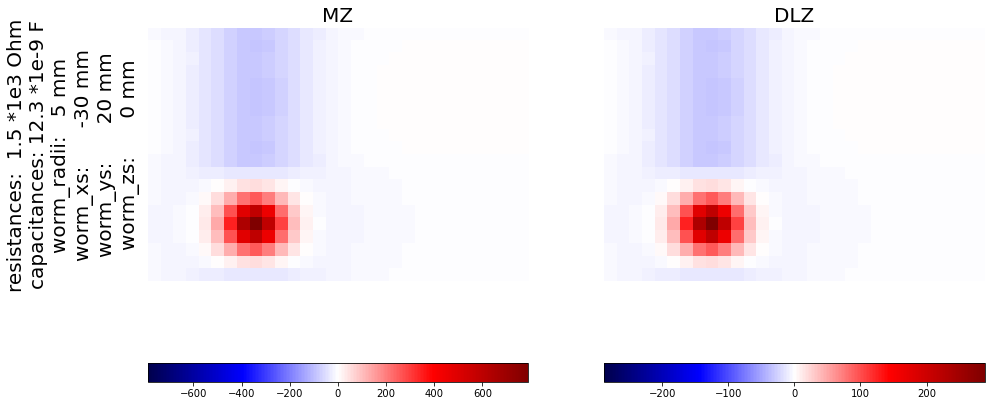

In [8]:
selected_EI = IMG_pert_EI[pert_EI_id]
max_mod = np.abs(selected_EI).max((1,2))

f = plt.figure(figsize=(15,10))
sub = f.add_subplot(1,2,1)
im = plt.imshow(selected_EI[0], vmin=-max_mod[0], vmax=max_mod[0], cmap='seismic')
plt.ylabel(f'resistances:  {resistances[resistances_id]/1e3:.1f} *1e3 Ohm\ncapacitances: {capacitances[capacitances_id]*1e9:.1f} *1e-9 F\nworm_radii:   {worm_radii[worm_radii_id]*1000:.0f} mm\nworm_xs:      {worm_xs[worm_xs_id]*1000:.0f} mm\nworm_ys:      {worm_ys[worm_ys_id]*1000:.0f} mm\nworm_zs:      {worm_zs[worm_zs_id]*1000:.0f} mm', 
           fontsize=20)

plt.title('MZ', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation = 'horizontal')
plt.box(False)

sub = f.add_subplot(1,2,2)
plt.imshow(selected_EI[1], vmin=-max_mod[1], vmax=max_mod[1], cmap='seismic')
plt.title('DLZ', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation = 'horizontal')
plt.box(False)

plt.show()

#### Average EI example from many examples

In [10]:
N_examples = 10000
select_examples = np.random.permutation(pert_EI.shape[0])[:N_examples]
select_examples.sort()

pert_EI_example = pert_EI[select_examples]
pert_EI_example = pert_EI_example[:,receptors_order]
pert_EI_example = pert_EI_example.reshape(N_examples, N_xx, N_yy, -1)

# electric image after base cancellation
pert_only_EI = pert_EI_example - base_EI_ordered
avg_pert_only_EI = np.concatenate([pert_only_EI.mean(0), np.zeros([pert_only_EI.shape[1], pert_only_EI.shape[2],1])], axis=-1)

color_avg_EI = (avg_pert_only_EI - avg_pert_only_EI.reshape(-1,3).min()) / (avg_pert_only_EI.reshape(-1,3).ptp()+1e-10)
plt.imshow(color_avg_EI)
plt.show()

color_avg_EI = (avg_pert_only_EI - avg_pert_only_EI.reshape(-1,3).min(0)) / (avg_pert_only_EI.reshape(-1,3).ptp(0)+1e-10)
plt.imshow(color_avg_EI)
plt.show()

# Check Feature Space

In [17]:
# worm_xs_id = 4
# worm_ys_id = 1
# worm_zs_id = 2
# worm_position = np.array([worm_xs[worm_xs_id], worm_ys[worm_ys_id], worm_zs[worm_zs_id]])
# receptors = fish_objs[base_EI_id].get_receptors_locations()
# receptor_id = np.linalg.norm(receptors - worm_position, axis=1).argmin()

idx = (
    (properties_ids_pert[:,properties_dict['water_conductivity']] == 0) & 
    (properties_ids_pert[:,properties_dict['boundary_normals']] == 0) &
    (properties_ids_pert[:,properties_dict['boundary_displacements']] == 0) & 
    (properties_ids_pert[:,properties_dict['tail_lateral_angle']] == 0) & 
    (properties_ids_pert[:,properties_dict['tail_dor_ven_angle']] == 0) & 
    (properties_ids_pert[:,properties_dict['tail_location_percent']] == 0) & 
    (properties_ids_pert[:,properties_dict['fish_yaw']] == 0) & 
    (properties_ids_pert[:,properties_dict['fish_pitch']] == 0) & 
    (properties_ids_pert[:,properties_dict['fish_roll']] == 0) & 
    # (properties_ids_pert[:,properties_dict['resistances']] == resistances_id) & 
    # (properties_ids_pert[:,properties_dict['resistances']] % 4 == 0) & 
    # (properties_ids_pert[:,properties_dict['capacitances']] == capacitances_id) & 
    # (properties_ids_pert[:,properties_dict['capacitances']] % 4 == 0) & 
    # (properties_ids_pert[:,properties_dict['worm_radii']] == 4) & 
    (properties_ids_pert[:,properties_dict['worm_xs']] == 4) & 
    (properties_ids_pert[:,properties_dict['worm_ys']] == 2) & 
    (properties_ids_pert[:,properties_dict['worm_zs']] == 2), 
)[0]

relevant_ids = properties_ids_pert[idx, properties_dict['pert_EI']]
distances = worm_ys[   properties_ids_pert[idx, properties_dict['worm_ys'   ]]] - 0.007
radii     = worm_radii[properties_ids_pert[idx, properties_dict['worm_radii']]]
relevant_EIs = pert_EI[relevant_ids] - base_EI[base_EI_id]
temp1, temp2 = np.unique(np.abs(relevant_EIs).argmax(1), return_counts=True)
print(temp1[temp2.argmax()], temp1, temp2)  # , receptor_id)
relevant_feats = relevant_EIs[:,temp1[temp2.argmax()]]
receptors_loc = fish_objs[0].get_receptors_locations().copy()
print(receptors_loc[temp1[temp2.argmax()]])  # , worm_position)

542 [542] [4000]
[-0.00758621  0.00614412 -0.00670815]


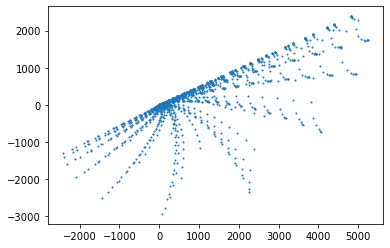

In [18]:
plt.scatter(*relevant_feats.T, s=1)
# plt.scatter(*relevant_feats.T, s=10, c=properties_ids_pert[idx, properties_dict['capacitances']])
# plt.xlim([-1,1])
# plt.ylim([-1,1])
plt.show()

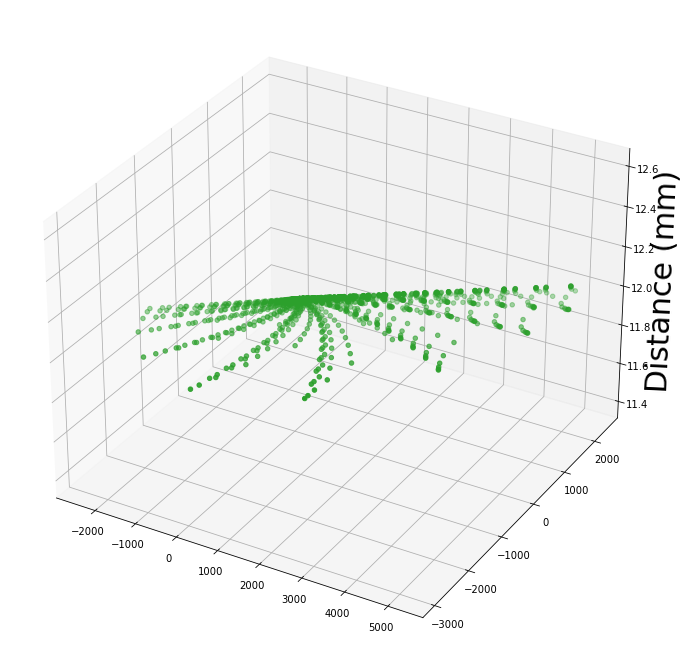

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(relevant_feats[:,0], relevant_feats[:,1], distances*1e3, c=[f'C{i}' for i in properties_ids_pert[idx, properties_dict['worm_ys']]])
ax.set_zlabel('Distance (mm)', fontsize=30)
plt.show()

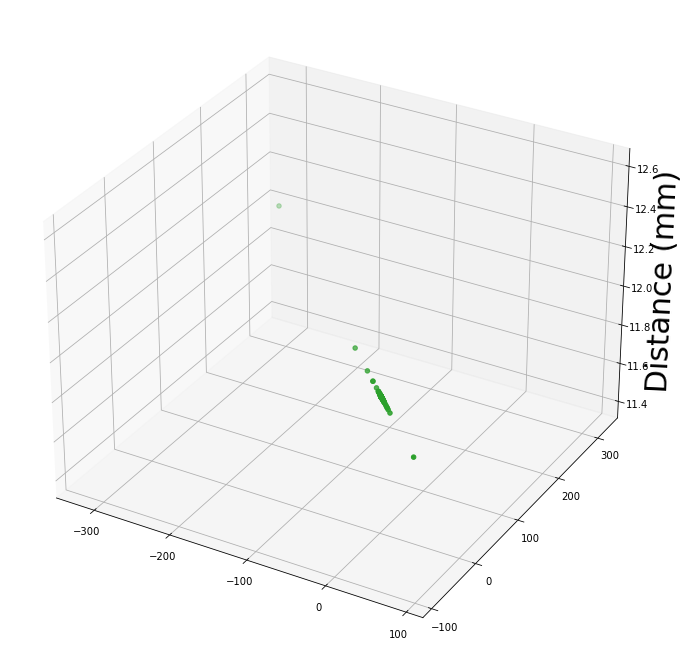

In [21]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(relevant_feats[:,0]/relevant_feats.sum(1), relevant_feats[:,1]/relevant_feats.sum(1), distances*1e3, c=[f'C{i}' for i in properties_ids_pert[idx, properties_dict['worm_ys']]])
ax.set_zlabel('Distance (mm)', fontsize=30)
plt.show()

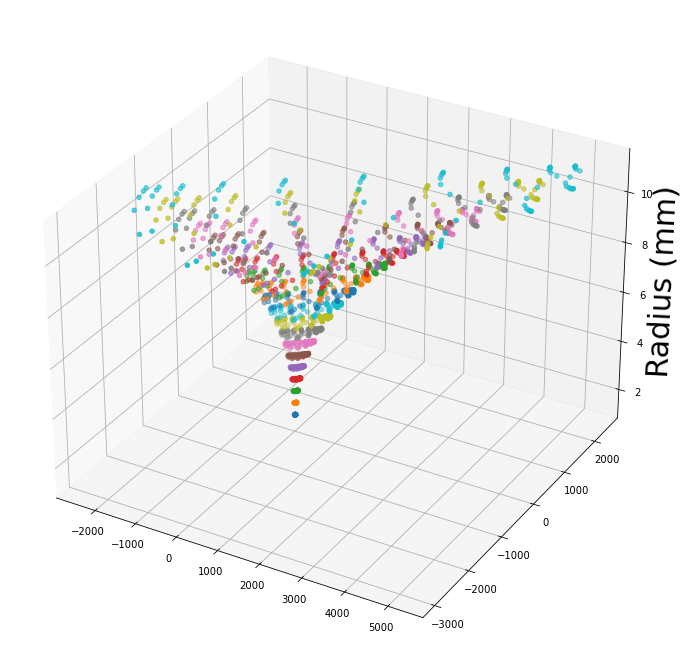

In [22]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(relevant_feats[:,0], relevant_feats[:,1], radii*1e3, c=[f'C{i}' for i in properties_ids_pert[idx, properties_dict['worm_radii']]])
ax.set_zlabel('Radius (mm)', fontsize=30)
plt.show()

# Save Data: Feats with Dist & Rad -> predict R & C

In [8]:
# test_idx = (
#     (properties_ids_pert[:,properties_dict['water_conductivity']] == 0) & 
#     (properties_ids_pert[:,properties_dict['boundary_normals']] == 0) &
#     (properties_ids_pert[:,properties_dict['boundary_displacements']] == 0) & 
#     (properties_ids_pert[:,properties_dict['tail_lateral_angle']] == 0) & 
#     (properties_ids_pert[:,properties_dict['tail_dor_ven_angle']] == 0) & 
#     (properties_ids_pert[:,properties_dict['tail_location_percent']] == 0) & 
#     (properties_ids_pert[:,properties_dict['fish_yaw']] == 0) & 
#     (properties_ids_pert[:,properties_dict['fish_pitch']] == 0) & 
#     (properties_ids_pert[:,properties_dict['fish_roll']] == 0) & 
#     (properties_ids_pert[:,properties_dict['worm_xs']] == 4) & 
#     (properties_ids_pert[:,properties_dict['worm_zs']] == 2), 
# )[0]

# print(test_idx.shape, test_idx.sum())

# worm_xs_id = 4
# worm_ys_id = 1
# worm_zs_id = 2
# worm_position = np.array([worm_xs[worm_xs_id], worm_ys[worm_ys_id], worm_zs[worm_zs_id]])
# receptors = fish_objs[base_EI_id].get_receptors_locations()
# receptor_id = np.linalg.norm(receptors - worm_position, axis=1).argmin()
# print(receptor_id)

# relevant_ids = properties_ids_pert[test_idx, properties_dict['pert_EI']]
# distances = worm_ys[   properties_ids_pert[test_idx, properties_dict['worm_ys'   ]]] - 0.007
# radii     = worm_radii[properties_ids_pert[test_idx, properties_dict['worm_radii']]]
# distances_ids = properties_ids_pert[test_idx, properties_dict['worm_ys'   ]]
# radii_ids     = properties_ids_pert[test_idx, properties_dict['worm_radii'   ]]

# print('Done1')
# relevant_feats = pert_EI[:,receptor_id]
# print('Done2')
# relevant_feats = relevant_feats[relevant_ids]
# print('Done3')
# relevant_feats = relevant_feats - base_EI[base_EI_id, receptor_id]

# print(relevant_feats.shape)

(19600000,) 560000
9
Done1
Done2
Done3
(560000, 2)


In [28]:
# dill.dump(
#     dict(feats=relevant_feats, 
#          distances=distances, 
#          radii=radii, 
#          ids_dis=distances_ids, 
#          ids_rad=radii_ids,
#          resistances=resistances[properties_ids_pert[test_idx, properties_dict['resistances']]],
#          capacitances=capacitances[properties_ids_pert[test_idx, properties_dict['capacitances']]],
#          ids_res = properties_ids_pert[test_idx, properties_dict['resistances']],
#          ids_cap = properties_ids_pert[test_idx, properties_dict['capacitances']]),
#     open('data_feats_dists_rads_R_C.pkl', 'wb')
# )

In [4]:
data_dict = dill.load(open('../data/data_feats_dists_rads_R_C.pkl', 'rb'))

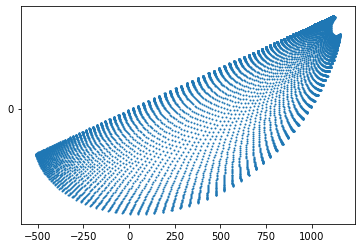

In [5]:
selected_idx = (
    (data_dict['ids_rad']==7) & 
    ((data_dict['ids_dis']==5))#  &
    # (data_dict['ids_res']>42) & 
    # (data_dict['ids_cap']>42)
)
# data_dict['feats']        = data_dict['feats'][selected_idx]
# data_dict['distances']    = data_dict['distances'][selected_idx]
# data_dict['radii']        = data_dict['radii'][selected_idx]
# data_dict['resistances']  = data_dict['resistances'][selected_idx]
# data_dict['capacitances'] = data_dict['capacitances'][selected_idx]

plt.scatter(*data_dict['feats'][selected_idx].T, s=1)
plt.yticks([0])
plt.show()

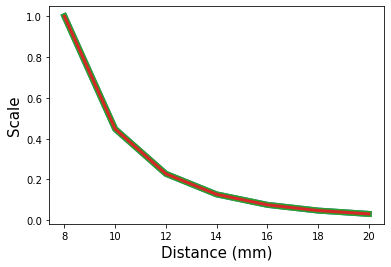

In [6]:
perts = []
ptps  = []
for i in np.arange(len(np.unique(data_dict['ids_dis']))):
    selected_idx = (
        (data_dict['ids_rad']==4) & 
        (data_dict['ids_dis']==i)  &
        (data_dict['ids_res']==34) & 
        (data_dict['ids_cap']==51)
    )
    perts.append(data_dict['feats'][selected_idx])
    selected_idx = (
        (data_dict['ids_rad']==4) & 
        (data_dict['ids_dis']==i)
    )
    ptps.append(data_dict['feats'][selected_idx].ptp(0))
perts = np.array(perts).squeeze().T
ptps = np.array(ptps).squeeze().T

dists = np.unique(data_dict['distances'])
for i, pert in enumerate(perts):
    plt.plot(dists*1e3, pert/pert[0], lw=(6-3*i))
for i, ptp in enumerate(ptps):
    plt.plot(dists*1e3, ptp/ptp[0], lw=(6-3*i))
plt.xlabel('Distance (mm)', fontsize=15)
plt.ylabel('Scale', fontsize=15)
plt.show()

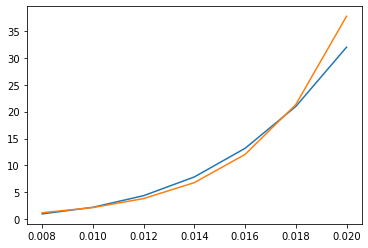

In [7]:
ys = ptp[0]/ptp
xs = dists

a1, a0 = np.polyfit(xs, np.log(ys), 1)

ys_ = np.exp(a1*xs + a0)

plt.plot(xs, ys)
plt.plot(xs, ys_)
plt.show()

In [8]:
(np.random.randn(5) * np.power(dists[:,np.newaxis]*1e3, (0,1,2,3,4))).sum(-1,keepdims=True)

array([[  545.03117584],
       [ 1114.32713564],
       [ 2021.40785611],
       [ 3369.31858717],
       [ 5272.99943105],
       [ 7859.28534235],
       [11266.90612796]])

4
3
2
1
0


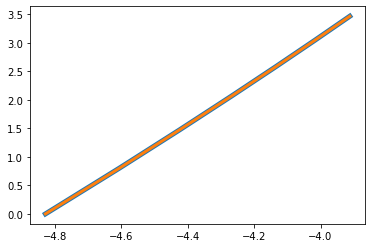

In [9]:
poly_deg = 4

ys = ptp[0]/ptp
xs = dists

as_ = np.polyfit(xs, ys, poly_deg)

ys_ = 0
for i in range(poly_deg+1):
    print((poly_deg-i))
    ys_ += as_[i] * (xs ** (poly_deg-i))

plt.plot(np.log(xs), np.log(ys), lw=5)
plt.plot(np.log(xs), np.log(ys_), lw=3)
plt.show()

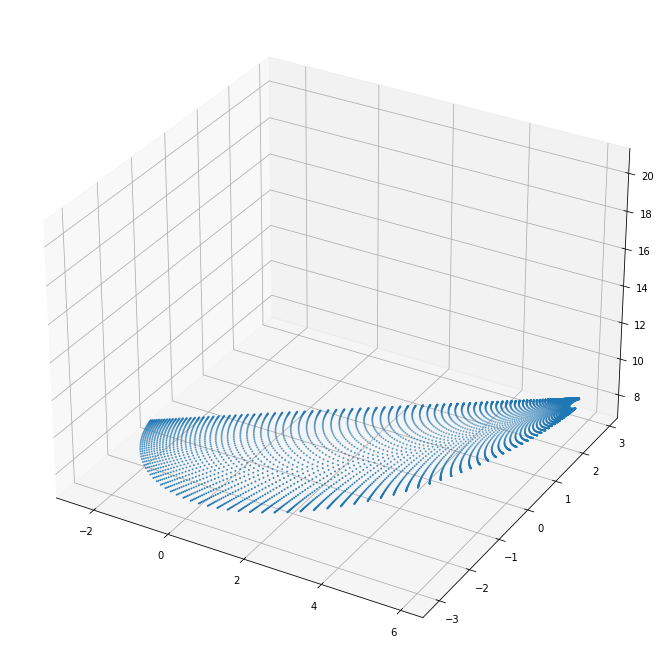

In [13]:
mod_feats = (data_dict['feats']) # + \
            #  np.random.randn(*data_dict['feats'].shape) * ptps.max(1) * 2e-3) #* \
            # ys_[data_dict['ids_dis']][:,np.newaxis]
            # (pert[0]/pert)[data_dict['ids_dis']][:,np.newaxis]
            #  np.random.randn(*data_dict['feats'].shape) * ptps[:,data_dict['ids_dis']].T * 1e-2) * \
            #  0) * \

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
for i in np.arange(len(np.unique(data_dict['ids_dis']))):
    selected_idx = (
        (data_dict['ids_rad']==4) &
        (data_dict['ids_dis']==i) &
        (data_dict['ids_res']%1==0) &
        (data_dict['ids_cap']%1==0)
    )
    temp = mod_feats[selected_idx]

    ax.scatter(temp[:,0]/1000, temp[:,1]/1000, np.ones(temp.shape[0])*dists[i]*1e3, c=f'C{i}', s=1/(np.sqrt(i+1)))
ax.set_zlabel('Distance (mm)', fontsize=30)
plt.show()

In [18]:
#####################################################
#####################################################
# PLOT THE 3D figures for Cosyne24 Talk
#####################################################
#####################################################

mod_feats = (data_dict['feats'])

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
for i in np.arange(len(np.unique(data_dict['ids_dis']))):
    selected_idx = (
        (data_dict['ids_rad']==4) &
        (data_dict['ids_dis']==i) &
        (data_dict['ids_res']%1==0) &
        (data_dict['ids_cap']%1==0)
    )
    temp = mod_feats[selected_idx]

    ax.scatter(temp[:,0]/1000, temp[:,1]/1000, np.ones(temp.shape[0])*dists[i]*1e3, c=f'C{i}', s=1/(np.sqrt(i+1)))
    ax.set_zlim(7,21)
plt.savefig('3D_feat_space.png', dpi=300, bbox_inches='tight', pad_inches=0)
    # break

In [50]:
perts = []
ptps  = []
for i in np.arange(len(np.unique(data_dict['ids_rad']))):
    selected_idx = (
        (data_dict['ids_rad']==i) &
        (data_dict['ids_dis']==1)  &
        (data_dict['ids_res']==34) &
        (data_dict['ids_cap']==51)
    )
    perts.append(data_dict['feats'][selected_idx])
    selected_idx = (
        (data_dict['ids_rad']==i) & 
        (data_dict['ids_dis']==1)
    )
    ptps.append(data_dict['feats'][selected_idx].ptp(0))
perts = np.array(perts).squeeze().T
ptps = np.array(ptps).squeeze().T

rads = np.unique(data_dict['radii'])
for i, pert in enumerate(perts):
    plt.plot(rads*1e3, pert/pert[0], lw=(6-3*i))
for i, ptp in enumerate(ptps):
    plt.plot(rads*1e3, ptp/ptp[0], lw=(6-3*i))
plt.xlabel('Radius (mm)', fontsize=15)
plt.ylabel('Scale', fontsize=15)
plt.show()

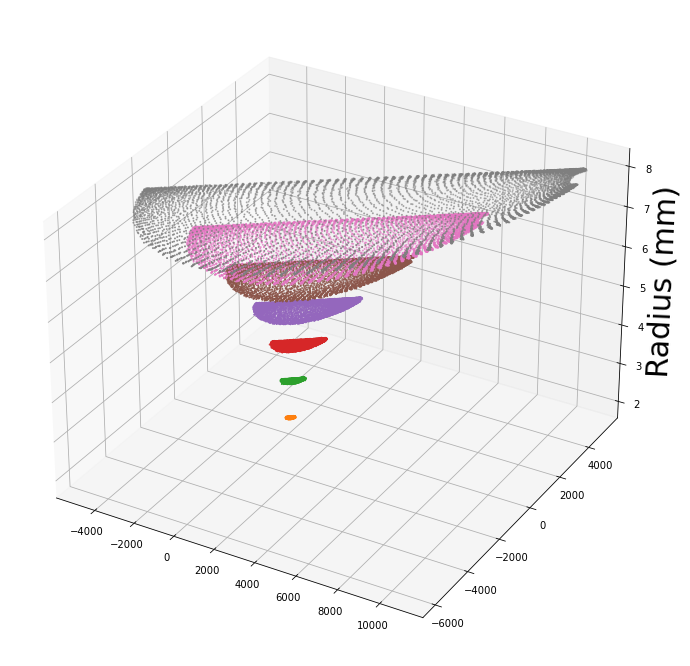

In [48]:
mod_feats = (data_dict['feats'] + \
             np.random.randn(*data_dict['feats'].shape) * ptps.max(1) * 2e-3) #* \
            # (ptps[0,0]/ptps[0])[data_dict['ids_rad']][:,np.newaxis]
            # (pert[0]/pert)[data_dict['ids_rad']][:,np.newaxis]
            #  np.random.randn(*data_dict['feats'].shape) * ptps[:,data_dict['ids_dis']].T * 1e-2) * \

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
for i in np.arange(1,len(np.unique(data_dict['ids_rad']))):
    selected_idx = (
        (data_dict['ids_rad']==i) & 
        (data_dict['ids_dis']==1)
    )
    temp = mod_feats[selected_idx]

    ax.scatter(temp[:,0], temp[:,1], np.ones(temp.shape[0])*rads[i]*1e3, c=f'C{i}', s=1)
ax.set_zlabel('Radius (mm)', fontsize=30)
plt.show()

In [49]:
f = plt.figure(figsize=(35,7))
n_cols = len(np.unique(data_dict['ids_rad']))
for i in range(n_cols):
    sub = f.add_subplot(1, n_cols, i+1)
    selected_idx = ((data_dict['ids_rad']==i) & ((data_dict['ids_dis']==1)))
    plt.scatter(*data_dict['feats'][selected_idx].T, s=2, c=data_dict['ids_res'][selected_idx], cmap='seismic')
    plt.scatter([0],[0],s=50, marker='X', c='k')
    plt.title(f'r = {rads[i]*1e3} mm', fontsize=20)
# plt.xticks([0])
# plt.yticks([0])
plt.show()

## Visualize 3D EI

In [8]:
zone = 0
# intensity = (pert_EI[pert_EI_id,:,zone] - base_EI[base_EI_id,:,zone]) / receptors_std[:,zone]
# intensity = pert_EI[pert_EI_id,:,zone] / base_EI[base_EI_id,:,zone] - 1
intensity = pert_EI[pert_EI_id,:,zone] - base_EI[base_EI_id,:,zone]
# intensity = base_EI[base_EI_id,:,zone]
# intensity = pert_EI[pert_EI_id,:,zone]
# intensity = receptors_avg[:,zone]
# intensity = receptors_std[:,zone]
fish_objs[tail_lateral_angle_id].visualize_scatter(intensity=intensity, show_normals=2, show_point_currents=False, marker_alpha=1,
                                                        fig_width=1300, fig_height=400)
print()